In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

# Load dataset from library

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Divide into trained and unknown classes

In [7]:
CLASS_NUMBER = 10
KEEP_CLASS_NUMBER = 8

keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train.flatten(), keep_classes)
test_keep_mask = np.isin(y_test.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train.flatten(), other_classes)
test_unknown_mask = np.isin(y_test.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test[test_unknown_mask]

In [8]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({6: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 3: 5000, 5: 5000, 0: 5000})
Test labels and counts: Counter({3: 1000, 0: 1000, 6: 1000, 1: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})
Unknown train labels and counts: Counter({9: 5000, 8: 5000})
Unknown test labels and counts: Counter({8: 1000, 9: 1000})


# Plot class distribution

In [9]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

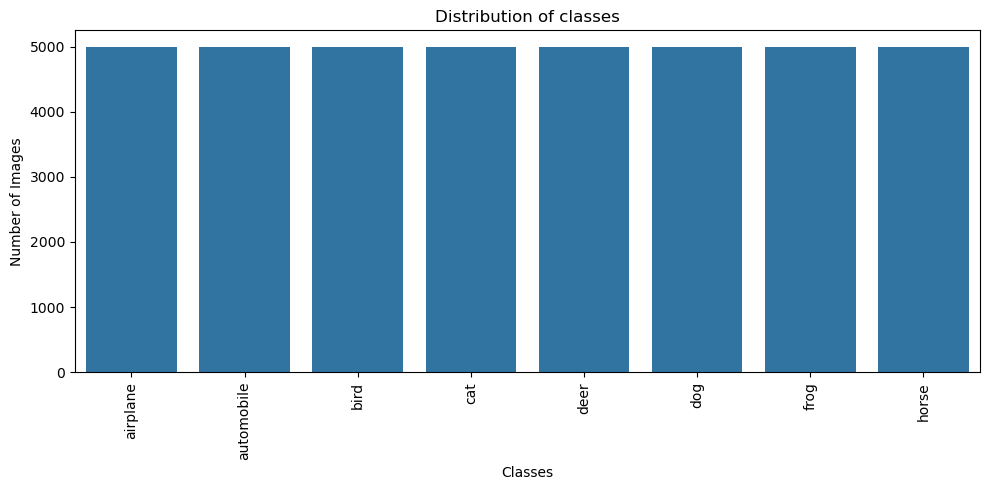

In [10]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

In [11]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

## Known classes

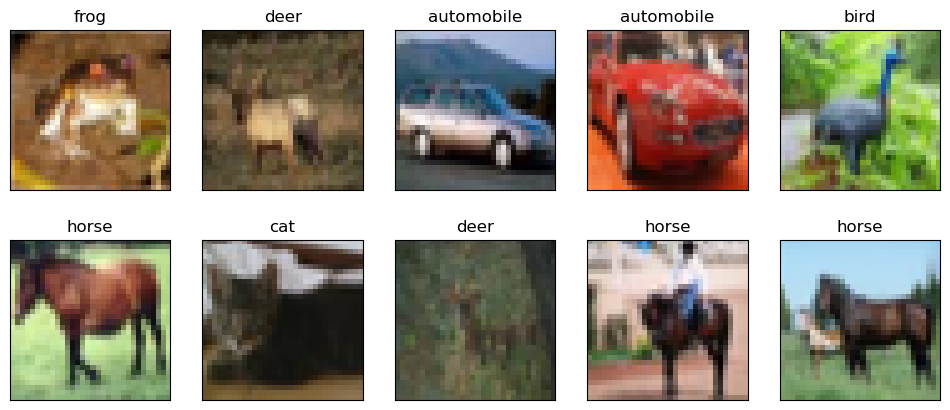

In [12]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

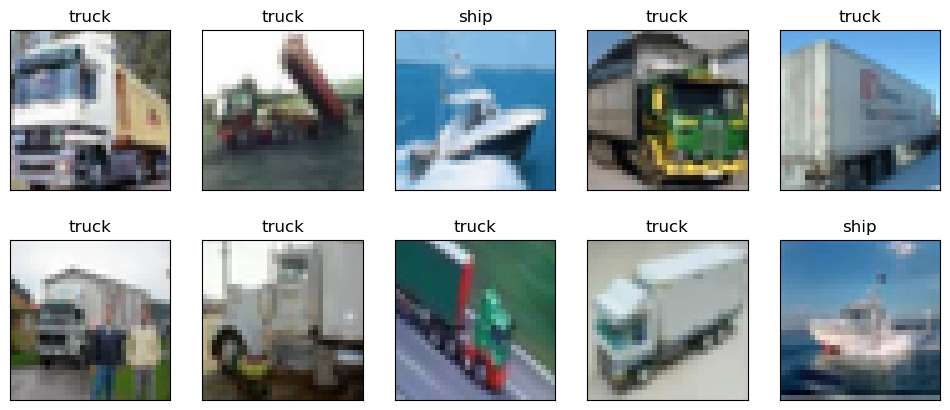

In [13]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [14]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [340]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [341]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=256,
    shuffle=False
)

# Fit simple CNN for classification

In [342]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [346]:
my_model = build_simple_cnn()

### Compile model

In [347]:
my_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Fit model

In [348]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
125/125 [==============================] - 67s 525ms/step - loss: 1.7937 - accuracy: 0.3406 - val_loss: 3.7671 - val_accuracy: 0.1325
Epoch 2/50
125/125 [==============================] - 63s 506ms/step - loss: 1.4553 - accuracy: 0.4650 - val_loss: 4.8459 - val_accuracy: 0.1916
Epoch 3/50
125/125 [==============================] - 63s 504ms/step - loss: 1.3237 - accuracy: 0.5177 - val_loss: 3.5706 - val_accuracy: 0.2554
Epoch 4/50
125/125 [==============================] - 63s 501ms/step - loss: 1.2173 - accuracy: 0.5563 - val_loss: 1.4182 - val_accuracy: 0.4845
Epoch 5/50
125/125 [==============================] - 63s 502ms/step - loss: 1.1338 - accuracy: 0.5907 - val_loss: 1.1998 - val_accuracy: 0.5480
Epoch 6/50
125/125 [==============================] - 62s 494ms/step - loss: 1.0795 - accuracy: 0.6133 - val_loss: 1.0135 - val_accuracy: 0.6260
Epoch 7/50
125/125 [==============================] - 58s 466ms/step - loss: 1.0254 - accuracy: 0.6361 - val_loss: 1.1087 - val_ac

### Get intermediate models

In [349]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

In [350]:
# Step 1: Get 1000 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 1000), random_state=SEED, shuffle=True
)

# Step 2: Get 4000 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4000), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [351]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [352]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=False, seed=SEED)
subset_test_flow = train_generator.flow(X_unknown_subset, y_unknown_subset, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [353]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 1s 164ms/step


In [354]:
train_features_cnn.shape, test_features_cnn.shape

((5000, 2048), (1000, 2048))

### Reduce feature number

In [355]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [356]:
train_reduced_cnn.shape, test_reduced_cnn.shape

((5000, 256), (1000, 256))

### Fit isolation forest

In [357]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)
    outlier_indices = np.where(predictions == -1)[0]

    # Select only the outliers from the original arrays
    return anomaly_scores, outlier_indices

In [358]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [359]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [360]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.2, 
    train_features = train_features_cnn, 
    test_features = train_features_cnn
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

### Display results

In [361]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.026905  -0.044494   0.075554   0.021708    airplane
1      1    0.004644  -0.058131   0.051620   0.018575  automobile
2      2    0.022751  -0.046751   0.068011   0.019390        bird
3      3    0.016619  -0.049278   0.074553   0.018109         cat
4      4    0.025722  -0.063903   0.065254   0.017579        deer
5      5    0.015275  -0.062257   0.062646   0.019260         dog
6      6    0.013776  -0.046098   0.065038   0.018038        frog
7      7    0.010787  -0.055224   0.055777   0.018517       horse
8      8    0.029752  -0.042862   0.071939   0.020835        ship
9      9    0.008869  -0.044885   0.055775   0.019237       truck


In [362]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     62    airplane
1      1    191  automobile
2      2     63        bird
3      3     98         cat
4      4     37        deer
5      5     93         dog
6      6    112        frog
7      7    139       horse
8      8     45        ship
9      9    160       truck


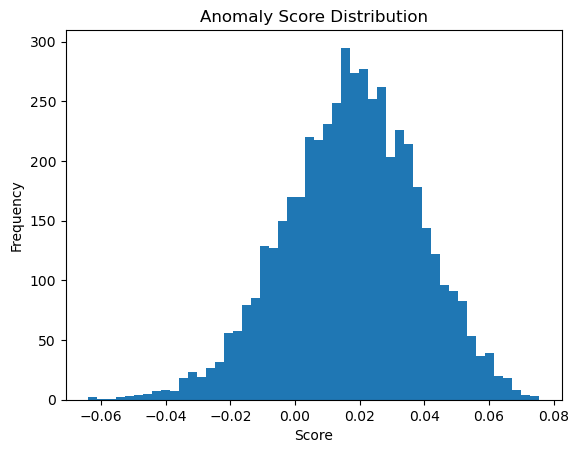

In [363]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [364]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 1s 167ms/step


In [365]:
train_features_dense.shape, test_features_dense.shape

((5000, 128), (1000, 128))

In [366]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = train_features_dense
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [367]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.040389  -0.044321   0.101251   0.030129    airplane
1      1    0.045092  -0.074547   0.097461   0.028700  automobile
2      2    0.045050  -0.064996   0.102832   0.033491        bird
3      3    0.056440  -0.044064   0.100376   0.027434         cat
4      4    0.039375  -0.084850   0.099257   0.031751        deer
5      5    0.044301  -0.086379   0.101676   0.034349         dog
6      6    0.025210  -0.118743   0.099924   0.043661        frog
7      7    0.042909  -0.079658   0.100600   0.032691       horse
8      8    0.059860  -0.036921   0.100954   0.024051        ship
9      9    0.066302  -0.057345   0.102755   0.023157       truck


In [368]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     59    airplane
1      1     39  automobile
2      2     49        bird
3      3     20         cat
4      4     66        deer
5      5     56         dog
6      6    141        frog
7      7     54       horse
8      8      9        ship
9      9      7       truck


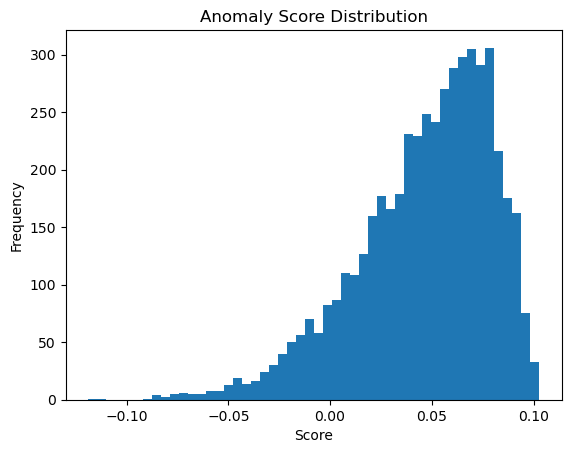

In [369]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [370]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 1s 161ms/step


In [371]:
train_features_logits.shape, test_features_logits.shape

((5000, 8), (1000, 8))

In [372]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = train_features_logits
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [373]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.078198  -0.091305   0.149306   0.045819    airplane
1      1    0.055767  -0.096592   0.141973   0.050699  automobile
2      2    0.092358  -0.058181   0.148398   0.044115        bird
3      3    0.089583  -0.102954   0.149715   0.046377         cat
4      4    0.083429  -0.114707   0.148753   0.046661        deer
5      5    0.061552  -0.144233   0.149340   0.066448         dog
6      6    0.059013  -0.092363   0.145941   0.054103        frog
7      7    0.051983  -0.128225   0.147604   0.060681       horse
8      8    0.102853  -0.044312   0.151269   0.031475        ship
9      9    0.092484  -0.070961   0.149390   0.035814       truck


In [374]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     37    airplane
1      1     85  automobile
2      2     22        bird
3      3     30         cat
4      4     34        deer
5      5     83         dog
6      6     85        frog
7      7    108       horse
8      8      5        ship
9      9     11       truck


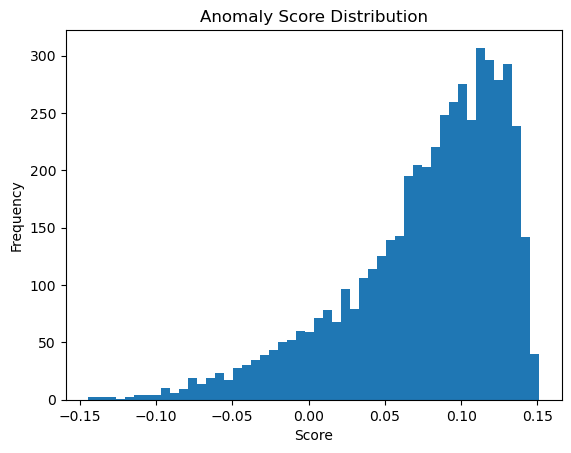

In [375]:
show_anomaly_score_plot(anomaly_scores)

## Model output

In [376]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

4/4 [==============================] - 1s 156ms/step


In [377]:
train_features.shape, test_features.shape

((5000, 8), (1000, 8))

In [378]:
anomaly_scores, outlier_indices = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = train_features_logits
)
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined, y_combined, outlier_indices, anomaly_scores)

In [379]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.078198  -0.091305   0.149306   0.045819    airplane
1      1    0.055767  -0.096592   0.141973   0.050699  automobile
2      2    0.092358  -0.058181   0.148398   0.044115        bird
3      3    0.089583  -0.102954   0.149715   0.046377         cat
4      4    0.083429  -0.114707   0.148753   0.046661        deer
5      5    0.061552  -0.144233   0.149340   0.066448         dog
6      6    0.059013  -0.092363   0.145941   0.054103        frog
7      7    0.051983  -0.128225   0.147604   0.060681       horse
8      8    0.102853  -0.044312   0.151269   0.031475        ship
9      9    0.092484  -0.070961   0.149390   0.035814       truck


In [380]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     37    airplane
1      1     85  automobile
2      2     22        bird
3      3     30         cat
4      4     34        deer
5      5     83         dog
6      6     85        frog
7      7    108       horse
8      8      5        ship
9      9     11       truck


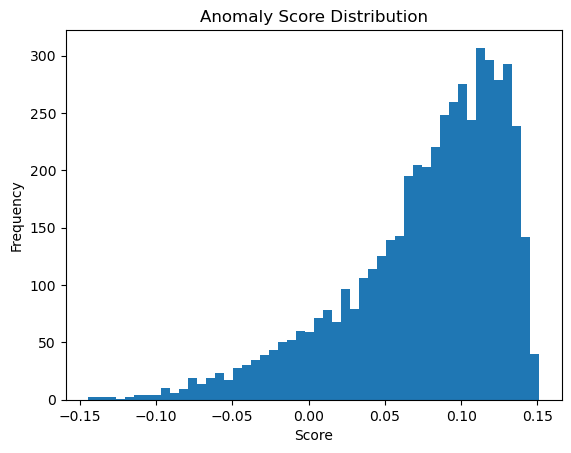

In [381]:
show_anomaly_score_plot(anomaly_scores)